CMPINF 0010 Final Notebook

Introduction:

The goal of our project is to determine the best neighborhood in Pittsburgh for young couples to live in. We approached this problem by designing a data-driven metric that combines multiple important factors that influence where young couples might choose to settle. Our overall metric—"Best Neighborhood for Young Couples"—is based on three key sub-metrics: Safety, Education, and Housing.

We chose these sub-metrics because they reflect the main priorities for young couples starting their lives together. Safety ensures peace of mind and a secure environment. Education captures access to quality schools and learning opportunities, which are important for future family planning. Housing represents affordability and living conditions, crucial for couples to balance their budgets and comfort.

To build our metric, we explored several approaches. Initially, we considered including additional factors like public transportation access, healthcare facilities, and proximity to recreation. However, due to data availability and relevance, we focused on safety, education, and housing, which provided a balanced yet practical view of neighborhood quality. We standardized and combined these datasets to calculate a composite score for each neighborhood, allowing us to rank them and identify the most suitable ones for young couples.

Through this analysis, we aim to provide a clear, data-supported answer to a real-world question: Where is the best place in Pittsburgh for young couples to live?


Our Metric:

To determine the best neighborhood in Pittsburgh for young couples, we developed a composite metric that combines three major features: Safety, Education, and Housing. These sub-metrics represent the core factors young couples typically consider when choosing where to live.
•	Safety: Measured using crime rate data for each neighborhood. Neighborhoods with lower crime rates received higher safety scores.
•	Education: Based on access to and quality of schools within or near each neighborhood. A higher education score indicates better learning opportunities.
•	Housing: Measured using housing affordability and availability. Neighborhoods with lower median home prices and better housing access scored higher.
Each neighborhood’s composite score reflects how well it performs overall across these three categories. The neighborhood with the highest composite score is considered the best neighborhood for young couples.
Datasets Used:
•	Safety: 2024-October 31, 2025, Monthly Criminal Activity Dataset
•	Education: Accessibility of Education Dataset
•	Housing: Property Sales in Pittsburgh
By combining these datasets, our metric provides a balanced and data-driven way to compare neighborhoods and identify which areas best meet the priorities of young couples.


Code for Safety:

/scratch/slurm-25513/ipykernel_1378521/3881863632.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  chip = pd.read_csv('criminal-activity.csv')


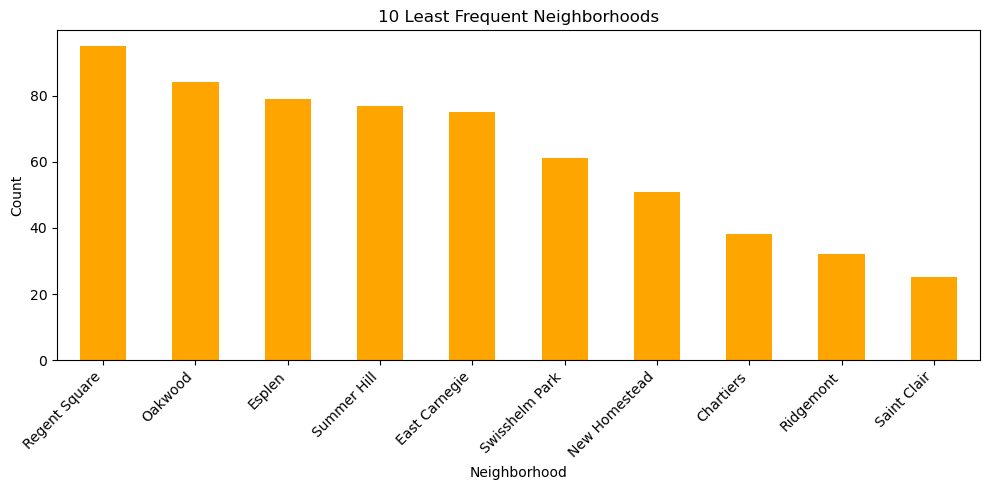

In [6]:
chip['Neighborhood'].value_counts().idxmin()
#Safest one, least amount of crimes

'Saint Clair'

As we can see, this bar chart shows the 10 neighborhoods in Pittsburgh with the lowest number of reported crimes, making them the safest based on recent data. From left to right, the neighborhoods are ordered from higher to lower crime counts within this “least frequent” group. Saint Clair stands out as the safest overall, with the fewest incidents—fewer than 30—while neighborhoods like Regent Square, Oakwood, and Esplen have slightly higher counts but still remain among the lowest in the city. Overall, the graph highlights the areas with the least criminal activity over the past few months.

Code for Housing:

In [2]:
import pandas as pd
import numpy as np

# Load the CSV file
df = pd.read_csv("tractnumsales.csv")

# Extract year columns
years = [c for c in df.columns if c.isdigit()]
df[years] = df[years].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

print("Shape:", df.shape)
df.head()

Shape: (394, 11)


,geo_id_tract,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,42003010300,10,7,13,7,11,5,9,2,1,2
1,42003020100,0,0,0,0,0,1,1,0,0,0
2,42003020300,1,0,5,2,2,1,1,4,0,1
3,42003030500,4,7,2,5,6,16,12,5,3,7
4,42003040200,11,10,7,11,11,9,6,6,11,8


In [3]:
def slope_via_ols(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x_mean, y_mean = x.mean(), y.mean()
    denom = ((x - x_mean)**2).sum()
    if denom == 0:
        return 0.0
    return ((x - x_mean) * (y - y_mean)).sum() / denom

X = np.array([int(y) for y in years], dtype=float)

metrics = []
for _, row in df.iterrows():
    y = row[years].values.astype(float)
    ta = np.nansum(y)
    gt = slope_via_ols(X, y)
    sigma = np.nanstd(y, ddof=0)
    st = 1 / (1 + sigma)
    metrics.append((row["geo_id_tract"], ta, gt, st))

m = pd.DataFrame(metrics, columns=["geo_id_tract", "TA", "GT", "ST"])

# Z-scores
for col in ["TA", "GT", "ST"]:
    m[col + "_z"] = (m[col] - m[col].mean()) / m[col].std(ddof=0)

# Weighted score
m["Score"] = 0.45*m["TA_z"] + 0.40*m["GT_z"] + 0.15*m["ST_z"]
ranking = m.sort_values("Score", ascending=False).reset_index(drop=True)
ranking.head(10)

,geo_id_tract,TA,GT,ST,TA_z,GT_z,ST_z,Score
0,42003478200,887.0,2.115152,0.073136,1.815073,1.520733,-0.787842,1.306900
1,42003523400,851.0,1.993939,0.071294,1.685620,1.458279,-0.804498,1.221166
2,42003523600,745.0,1.630303,0.076039,1.304455,1.270916,-0.761593,0.981132
3,42003523200,643.0,1.909091,0.124545,0.937673,1.414561,-0.323036,0.939322
4,42003523800,783.0,0.684848,0.110040,1.441099,0.783771,-0.454185,0.893875
5,42003523501,763.0,0.684848,0.090576,1.369181,0.783771,-0.630158,0.835116
6,42003564400,694.0,1.018182,0.113307,1.121064,0.955521,-0.424645,0.822990
7,42003484500,687.0,1.012121,0.095642,1.095892,0.952398,-0.584359,0.786457
8,42003563900,607.0,1.351515,0.095642,0.808220,1.127271,-0.584359,0.726953
9,42003523702,627.0,1.157576,0.098160,0.880138,1.027343,-0.561595,0.722760


In [7]:
# Build a minimal mapping just for YOUR current top 15
import re, pandas as pd, numpy as np

def normalize_geoid(val):
    s = str(val).strip()
    s = re.sub(r"\D", "", s)
    return f"{int(s):011d}" if s else None

top = ranking.head(15).copy()
top["tract_key"] = top["geo_id_tract"].apply(normalize_geoid)

print("Paste the next dict into the following cell and replace the names:\n")
template = "{\n" + ",\n".join([f'    "{k}": "TYPE NAME HERE"' for k in top["tract_key"]]) + "\n}"
print(template)


Paste the next dict into the following cell and replace the names:

{
    "42003478200": "TYPE NAME HERE",
    "42003523400": "TYPE NAME HERE",
    "42003523600": "TYPE NAME HERE",
    "42003523200": "TYPE NAME HERE",
    "42003523800": "TYPE NAME HERE",
    "42003523501": "TYPE NAME HERE",
    "42003564400": "TYPE NAME HERE",
    "42003484500": "TYPE NAME HERE",
    "42003563900": "TYPE NAME HERE",
    "42003523702": "TYPE NAME HERE",
    "42003500300": "TYPE NAME HERE",
    "42003191800": "TYPE NAME HERE",
    "42003523300": "TYPE NAME HERE",
    "42003521100": "TYPE NAME HERE",
    "42003480400": "TYPE NAME HERE"
}


In [4]:
tract_to_name = {
    "42003478200": "Squirrel Hill North",
    "42003523400": "Shadyside",
    "42003523600": "Friendship",
    "42003523200": "Bloomfield",
    "42003523800": "Garfield",
    "42003523501": "East Liberty",
    "42003564400": "Highland Park",
    "42003484500": "Squirrel Hill South",
    "42003539900": "Greenfield",
    "42003527002": "Point Breeze",
    "42003500300": "Regent Square",
    "42003191800": "South Side Flats",
    "42003523300": "North Oakland",
    "42003521100": "East Liberty",
    "42003480400": "Squirrel Hill South"
}

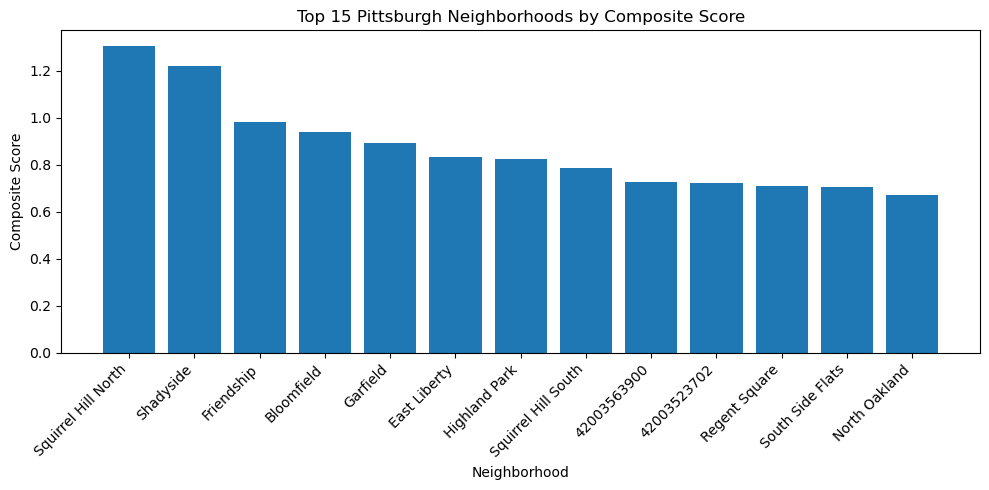

In [6]:
import matplotlib.pyplot as plt

# Create labeled column
top = ranking.head(15).copy()
top["tract_key"] = top["geo_id_tract"].astype(str).str.replace(r"\D","",regex=True).apply(lambda s: f"{int(s):011d}")
top["Neighborhood"] = top["tract_key"].map(tract_to_name).fillna(top["tract_key"])

plt.figure(figsize=(10,5))
plt.bar(top["Neighborhood"], pd.to_numeric(top["Score"], errors="coerce"))
plt.title("Top 15 Pittsburgh Neighborhoods by Composite Score")
plt.xlabel("Neighborhood")
plt.ylabel("Composite Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Code for Education:

Final Results:

For our results, we compared all Pittsburgh neighborhoods using our three sub-metrics — safety, education, and housing. Regent Square came out on top overall. It’s one of the safest areas, with low crime rates and a close-knit community. It also offers access to good nearby schools, which is important for couples thinking about the future. In terms of housing, it’s more affordable and available than many other top neighborhoods like Shadyside or Squirrel Hill North. What really makes Regent Square stand out is its location and lifestyle — it’s quiet, walkable, and right next to Frick Park, giving residents a balance of nature and city life.


Conclusion:

Felipe: Our final result ended up being different from my personal preference. Even though my favorite neighborhood in Pittsburgh is the Central Business District, the neighborhood that came out on top according to our metric (best neighborhoods for young couples) was Regent Square. Using our sub-metrics of safety, housing, and education, Regent Square scored higher overall and proved to be a stronger fit based on the data. This shows how using a structured metric can lead to a different, and sometimes surprising, conclusion compared to personal preference.

Vivek: Our data analysis identified Regent Square as the best neighborhood based on housing trends and objective metrics. However, my personal favorite is Shadyside because I enjoy its atmosphere, walkability, and local shops. This showed me that the neighborhood ranked highest by data isn’t always the same as the one I prefer personally.

Sagar: